In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import datetime as dt
from merge_data_barpa import load_stn_info
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import tqdm
import warnings

#For plotting soundings
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from metpy.calc import dewpoint_from_relative_humidity, dewpoint_from_specific_humidity
import glob
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset
from matplotlib.patches import Circle
import sharppy.plot.skew as skew
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#Code to register the "skewx" projection, from here https://matplotlib.org/stable/gallery/specialty_plots/skewt.html
from contextlib import ExitStack
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
from matplotlib.projections import register_projection


# The sole purpose of this class is to look at the upper, lower, or total
# interval as appropriate and see what parts of the tick to draw, if any.
class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        # When adding the callbacks with `stack.callback`, we fetch the current
        # visibility state of the artist with `get_visible`; the ExitStack will
        # restore these states (`set_visible`) at the end of the block (after
        # the draw).
        with ExitStack() as stack:
            for artist in [self.gridline, self.tick1line, self.tick2line,
                           self.label1, self.label2]:
                stack.callback(artist.set_visible, artist.get_visible())
            needs_lower = transforms.interval_contains(
                self.axes.lower_xlim, self.get_loc())
            needs_upper = transforms.interval_contains(
                self.axes.upper_xlim, self.get_loc())
            self.tick1line.set_visible(
                self.tick1line.get_visible() and needs_lower)
            self.label1.set_visible(
                self.label1.get_visible() and needs_lower)
            self.tick2line.set_visible(
                self.tick2line.get_visible() and needs_upper)
            self.label2.set_visible(
                self.label2.get_visible() and needs_upper)
            super().draw(renderer)

    def get_view_interval(self):
        return self.axes.xaxis.get_view_interval()


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def _get_tick(self, major):
        return SkewXTick(self.axes, None, major=major)

    def get_view_interval(self):
        return self.axes.upper_xlim[0], self.axes.lower_xlim[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        pts = self._path.vertices
        if self.spine_type == 'top':
            pts[:, 0] = self.axes.upper_xlim
        else:
            pts[:, 0] = self.axes.lower_xlim


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        # Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines.top.register_axis(self.xaxis)
        self.spines.bottom.register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines.left.register_axis(self.yaxis)
        self.spines.right.register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top': SkewSpine.linear_spine(self, 'top'),
                  'bottom': mspines.Spine.linear_spine(self, 'bottom'),
                  'left': mspines.Spine.linear_spine(self, 'left'),
                  'right': mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        # Get the standard transform setup from the Axes base class
        super()._set_lim_and_transforms()

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = (
            self.transScale
            + self.transLimits
            + transforms.Affine2D().skew_deg(rot, 0)
        )
        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (
            transforms.blended_transform_factory(
                self.transScale + self.transLimits,
                transforms.IdentityTransform())
            + transforms.Affine2D().skew_deg(rot, 0)
            + self.transAxes
        )

    @property
    def lower_xlim(self):
        return self.axes.viewLim.intervalx

    @property
    def upper_xlim(self):
        pts = [[0., 1.], [1., 1.]]
        return self.transDataToAxes.inverted().transform(pts)[:, 0]


# Now register the projection with matplotlib so the user can select it.
register_projection(SkewXAxes)

def plot_prof(prof, ax, ax2, gs, hodo_size=1.7):
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)

        # Set up the figure in matplotlib.
        ax.grid(True)
        plt.grid(True)      
        
        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.vtmp[~prof.vtmp.mask], prof.pres[~prof.vtmp.mask], 'r', lw=2)
        #ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        sfcpcl = params.parcelx( prof, flag=1 )
        mupcl = params.parcelx( prof, flag=3 )
        mlpcl = params.parcelx( prof, flag=4 )
        ax.semilogy(sfcpcl.ttrace, sfcpcl.ptrace, 'k:')
        ax.semilogy(mlpcl.ttrace, mlpcl.ptrace, color='tab:blue', ls=":")
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='tab:red', ls=":")

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        # [ax.text(-0.6, p, str(round(h/1000,1)) + " km", transform=ax.get_yaxis_transform(), va="center", size="x-large") 
        #      for h, p in zip(prof.hght[prof.pres >= 100][3:-1:2], prof.pres[prof.pres >= 100][3:-1:2])]

        # Plot the hodograph data.
        inset_axes = inset(ax,width=hodo_size, # width = 30% of parent_bbox
                                            height=hodo_size, # height : 1 inch
                                            loc=1)
        inset_axes.get_xaxis().set_visible(False)
        inset_axes.get_yaxis().set_visible(False)

        # Draw the range rings around the hodograph.
        for i in range(10,90,10):
            circle = Circle((0,0),i,color='k',alpha=.3, fill=False)
            if i % 10 == 0 and i <= 50:
                inset_axes.text(-i,2,str(i), fontsize=8, horizontalalignment='center')
            inset_axes.add_artist(circle)
        inset_axes.set_xlim(-60,60)
        inset_axes.set_ylim(-60,60)
        inset_axes.axhline(y=0, color='k')
        inset_axes.axvline(x=0, color='k')
        #srwind = tab.params.bunkers_storm_motion(prof)        
        skew.plotHodo(inset_axes, prof.hght, (prof.u), (prof.v), color='r')
        inset_axes.set_xlim([-50,60])
        inset_axes.set_ylim([-50,60])        

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        skew.plot_wind_axes(ax2)
        skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
        srwind = params.bunkers_storm_motion(prof)
        gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)       

        sfc = prof.pres[prof.sfc]
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        s06 = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1] * 0.514444
        print("MUCAPE: ",mupcl.bplus, "MLCAPE: ",mlpcl.bplus, "SBCAPE: ",sfcpcl.bplus, "S06: ",s06, "DCAPE",params.dcape(prof)[0])

In [6]:
barpa_profiles = [pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/composite_sounding_barpac_"+str(c)+".csv") for c in [1,2,0]]
era5_profiles = [pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/composite_sounding_era5_"+str(c)+".csv") for c in [1,2,0]]

In [7]:
barpa_cape = [pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/composite_sounding_mu_cape_barpac_"+str(c)+".csv") for c in [1,2,0]]
era5_cape = [pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/composite_sounding_mu_cape_era5_"+str(c)+".csv") for c in [1,2,0]]

MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  0.0 S06:  15.128530839031836 DCAPE 96.00476023566853


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  0.0 S06:  15.249850397993377 DCAPE 233.21744353005835


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  0.0 S06:  12.573593587194997 DCAPE 1231.8436914865347


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  0.0 MLCAPE:  0.0 SBCAPE:  0.0 S06:  13.737734934325173 DCAPE 1141.7628021907133


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  215.39939615880684 MLCAPE:  84.76011629726617 SBCAPE:  215.39939615880684 S06:  4.1442940918936895 DCAPE 899.9560056462633


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  407.1380397452816 MLCAPE:  201.07681006113415 SBCAPE:  407.1380397452816 S06:  6.0170433932604634 DCAPE 896.7598470320208


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


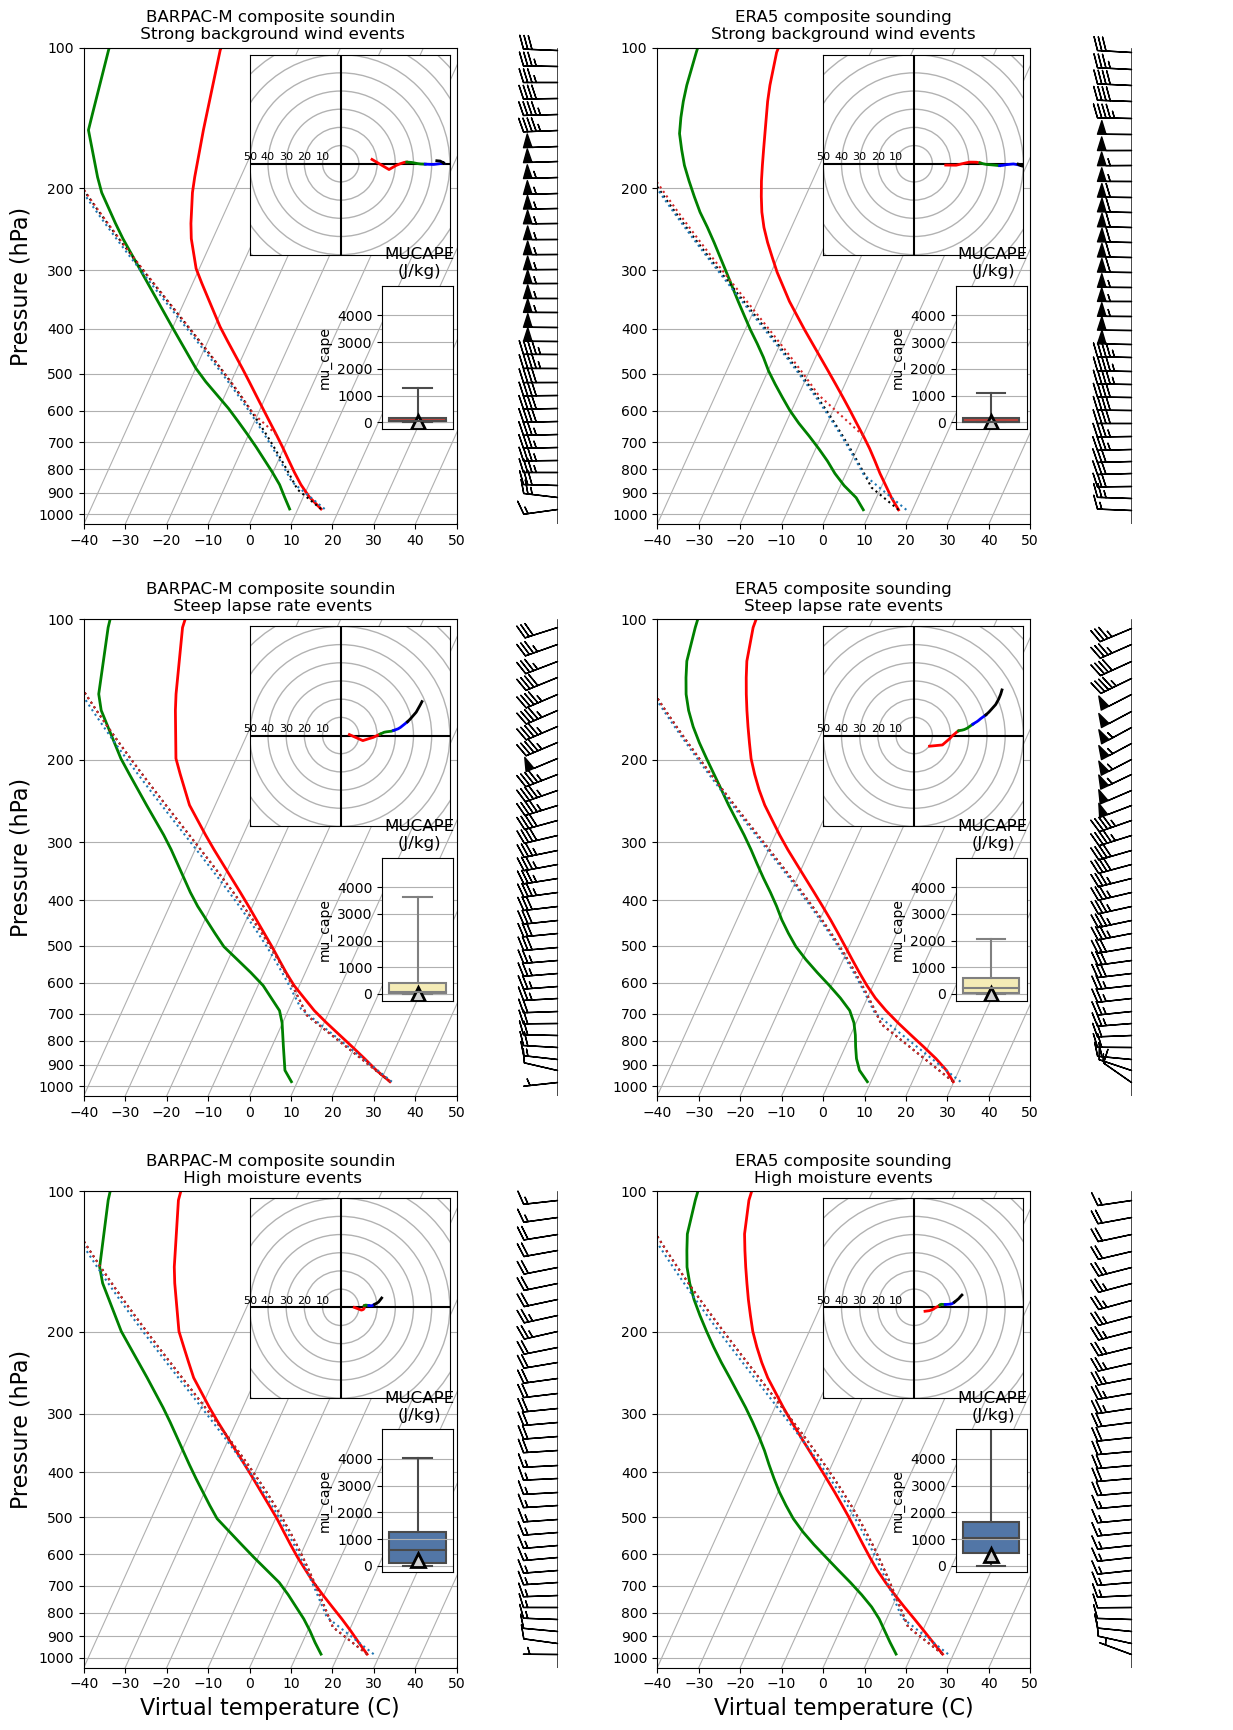

In [18]:
cluster_name = ["Strong background wind events","Steep lapse rate events","High moisture events"]
plt.figure(figsize=[12,18])
inset_palette = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
gs = gridspec.GridSpec(3,4, width_ratios=[2,1,2,1])
for c in [0,1,2]:

    prof = profile.create_profile(tmpc=barpa_profiles[c]["tmpc"], pres=barpa_profiles[c]["pres"], hght=barpa_profiles[c]["hgt"], 
                                  dwpc=barpa_profiles[c]["dwpc"], u=barpa_profiles[c]["u"], v=barpa_profiles[c]["v"], missing=np.nan)   
    prof_obs = profile.create_profile(tmpc=era5_profiles[c]["tmpc"], pres=era5_profiles[c]["pres"], hght=era5_profiles[c]["hgt"], 
                                  dwpc=era5_profiles[c]["dwpc"], u=era5_profiles[c]["u"], v=era5_profiles[c]["v"], missing=np.nan) 

    ax = plt.subplot(gs[c, 0], projection='skewx')
    ax2 = plt.subplot(gs[c, 1])
    plot_prof(prof, ax, ax2, gs, hodo_size=2)
    if c == 2:
        ax.set_xlabel("Virtual temperature (C)",size=16)
    ax.set_ylabel("Pressure (hPa)",size=16)    
    ax3=ax.inset_axes([0.8,0.2,0.19,0.3])
    sns.boxplot(y=barpa_cape[c]["mu_cape"],ax=ax3,whis=1000,color=inset_palette[c])
    ax3.set_ylim([-250,5100])
    ax3.grid("y")
    ax3.set_yticks([0,1000,2000,3000,4000])
    ax3.set_xticks([])
    plt.text(0.90,0.52,"MUCAPE\n(J/kg)",size=12,ha="center",transform=ax.transAxes)
    ax3.plot(0, params.parcelx( prof, flag=3 ).bplus, color="lightgray", marker="^", mec="k", mew=2, ms=10)
    ax3.tick_params(labelsize=10)
    ax.set_title("BARPAC-M composite soundin\n " + cluster_name[c])

    ax = plt.subplot(gs[c, 2], projection='skewx')
    ax2 = plt.subplot(gs[c, 3])
    plot_prof(prof_obs, ax, ax2, gs, hodo_size=2)
    if c == 2:
        ax.set_xlabel("Virtual temperature (C)",size=16)
    ax3=ax.inset_axes([0.8,0.2,0.19,0.3])
    sns.boxplot(y=era5_cape[c]["mu_cape"],ax=ax3,whis=1000,color=inset_palette[c])
    ax3.set_ylim([-250,5100])
    ax3.grid("y")
    ax3.set_yticks([0,1000,2000,3000,4000])
    ax3.set_xticks([])
    plt.text(0.90,0.52,"MUCAPE\n(J/kg)",size=12,ha="center",transform=ax.transAxes)
    ax3.plot(0, params.parcelx( prof_obs, flag=3 ).bplus, color="lightgray", marker="^", mec="k", mew=2, ms=10)
    ax3.tick_params(labelsize=10)
    ax.set_title("ERA5 composite sounding\n" + cluster_name[c])

([<matplotlib.axis.XTick at 0x153728e54400>,
 [Text(0, 0, 'BARPA-R'), Text(1, 0, 'ERA5')])

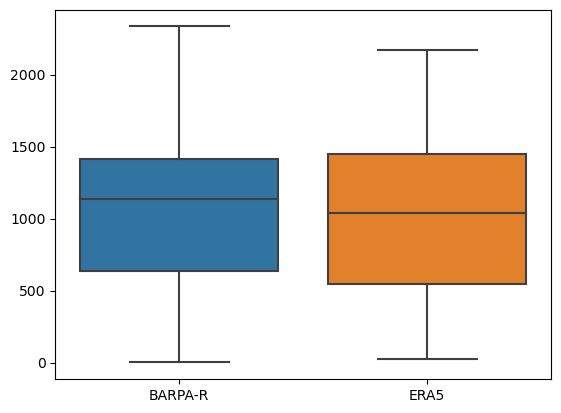

In [19]:
#Check the distribution of DCAPE

sns.boxplot(data=[barpa_cape[1]["dcape"], era5_cape[1]["dcape"]])
plt.xticks([0,1],["BARPA-R","ERA5"])